In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from clean_data import *

## Clean data and dimension reduction

In [20]:
# Prepare data for person 4. Use sequence 1~3 for training, 4~5 for testing.
person = 4
sadl_n = []
for n in range(1, 6):
    sadl_n.append(pd.read_table('data/S%d-ADL%d.dat' % (person, n), sep='\s+', header=None, dtype=float))

In [21]:
# Smooth data, time: col 0, features: col 1~36, labels: col 244 
winsize = 15
stepsize = 8

# train data
train_sample = np.empty((0, 36))
train_labels = np.empty((0))
train_len = []
for i in range(0, 3):
    print sadl_n[i].shape
    features = moving_avg(sadl_n[i].iloc[:, 1:37], winsize, stepsize)
    print features.shape
    labels = moving_vote_majority(sadl_n[i].iloc[:, 244], winsize, stepsize)
    train_sample = np.concatenate((train_sample, features), axis=0)
    train_len.append(features.shape[0])
    train_labels = np.concatenate( (train_labels, labels) )
train_len = np.array(train_len)

print "train_sample size: ", train_sample.shape
print "train_labels size: ", train_labels.shape
print "subsequence length: ", train_len, ". Sum of length: ", np.sum(train_len)

# test data
test_sample = np.empty((0, 36))
test_labels = np.empty((0))
test_len = []
for i in range(3, 5):
    features = moving_avg(sadl_n[i].iloc[:, 1:37], winsize, stepsize)
    labels = moving_vote_majority(sadl_n[i].iloc[:, 244], winsize, stepsize)
    test_sample = np.concatenate((test_sample, features), axis=0)
    test_len.append(features.shape[0])
    test_labels = np.concatenate( (test_labels, labels) )
test_len = np.array(test_len)  

print "test_sample size: ", test_sample.shape
print "test_labels size: ", test_labels.shape
print "subsequence length: ", test_len, ". Sum of length: ", np.sum(test_len)


(41588, 250)
(5198, 36)
(27737, 250)
(3467, 36)
(25132, 250)
(3141, 36)
train_sample size:  (11806, 36)
train_labels size:  (11806,)
subsequence length:  [5198 3467 3141] . Sum of length:  11806
test_sample size:  (6593, 36)
test_labels size:  (6593,)
subsequence length:  [2778 3815] . Sum of length:  6593


In [22]:
# Fill missing values
col_threshold = 0.5
train, test = fill_missing(train_sample, test_sample, col_threshold, True)
np.any(np.isnan(train)), np.any(np.isnan(test))
print train.shape

(11806, 36)


In [23]:
# Dimension reduction
# from sklearn.decomposition import PCA
# pca = PCA()
# pca.fit(train)
# var_thres = 0.95 # keep components to up to 95% total variance
# n_comp = (pca.explained_variance_ratio_.cumsum() < var_thres).sum() + 1
# print "Keep %d compoments to retrain %f variance" % (n_comp, var_thres)

# pca_train = PCA(n_components=n_comp)
# train_reduced = pca_train.fit_transform(train)
# test_reduced = pca_train.fit_transform(test)
# print "Size of reduced dimension training data: ", train_reduced.shape
# print "Size of reduced dimension testing data: ", test_reduced.shape

train_reduced = train
test_reduced = test

In [24]:
# Cleaned data: train_reduced, test_reduced, train_labels, test_labels, train_len, test_len


## Build hmm model

In [25]:
from hmm import DiscreteDistr, GaussDistr, GaussMixDistr
from hmm import MarkovChain
from hmm import HMM, make_leftright_hmm

# Build a left-right hmm with 6 states, discrete output distribution, the output is the discrete label of activity
label_transfer = (np.maximum(train_labels - 100, 0) + 1)[:, np.newaxis]
# transform the labels into range 1~6. {0: 1, 101: 2, 102: 3, 103: 4, 104: 5, 105: 6}
discreteD = DiscreteDistr(np.ones((6))) # a discrete distribution with 6 possible output
n_states = 6

hmm_state = make_leftright_hmm(n_states, discreteD, obs_data=label_transfer, l_data=train_len)
for i in range(0, n_states):
    print hmm_state.output_distr[i].prob_mass

[  8.22154811e-01   1.77845189e-01   0.00000000e+00   2.06379839e-15
   0.00000000e+00   0.00000000e+00]
[  1.19751267e-02   8.08906198e-33   3.03244686e-19   9.88024873e-01
   0.00000000e+00   0.00000000e+00]
[  5.64464436e-02   0.00000000e+00   9.43553556e-01   1.51923326e-24
   0.00000000e+00   1.60823554e-14]
[  1.02481218e-008   0.00000000e+000   1.17111254e-106   0.00000000e+000
   2.37302293e-036   9.99999990e-001]
[  3.35882575e-002   9.53584713e-229   0.00000000e+000   0.00000000e+000
   9.66411742e-001   2.03596214e-015]
[  7.70318295e-01   2.29681705e-01   0.00000000e+00   0.00000000e+00
   5.24460217e-14   0.00000000e+00]


In [26]:
# Assume there is 1-to-1 mapping between the hidden state and output label
# Assign max probability activity label to each state
state_act_label = np.array([np.argmax(hmm_state.output_distr[i].prob_mass) for i in range(0, n_states)])
act_label_count = np.zeros((n_states)) # how many states correspond to label i
for i in range(0, n_states):
    act_label_count[i] = np.sum(state_act_label == i)
print act_label_count, state_act_label

transition_prob = hmm_state.state_gen.transition_prob
print "transition prob for left-right hmm: "
print transition_prob
# Resolve conflicts: when multiple states have the same activity label (a bit of heuristic)
for n in range(0, n_states):
    if act_label_count[n] > 1:
        t_states = [j for j in range(0, n_states) if state_act_label[j] == n] # n is the activity label
        for s1 in t_states:
            # allow s1 to transition into other states in t_states
            for s2 in t_states:
                if s2 != s1:
                    transition_prob[s1, s2] += 1e-4
                    transition_prob[s1, s1] -= 1e-4

# Train new hmm
hmm_state.transition_prob = transition_prob
hmm_state.train(obs_data=label_transfer, l_data=train_len)

state_act_label = np.array([np.argmax(hmm_state.output_distr[i].prob_mass) for i in range(0, n_states)])
actlabel2state = np.argsort(state_act_label)
print "state to activity label: ", state_act_label
print "activity label to state:", actlabel2state

# Prune new hmm to leftright hmm
for i in range(0, n_states):
    for j in range(0, n_states):
        if j == i or j == i + 1:
            continue
        hmm_state.state_gen.transition_prob[i, j] = 0
        
print "transition prob before permutation:"
print hmm_state.state_gen.transition_prob

[ 2.  0.  1.  1.  1.  1.] [0 3 2 5 4 0]
transition prob for left-right hmm: 
[[ 0.99845352  0.00154648  0.          0.          0.          0.          0.        ]
 [ 0.          0.99857702  0.00142298  0.          0.          0.          0.        ]
 [ 0.          0.          0.99787965  0.00212035  0.          0.          0.        ]
 [ 0.          0.          0.          0.99897959  0.00102041  0.          0.        ]
 [ 0.          0.          0.          0.          0.99856331  0.00143669
   0.        ]
 [ 0.          0.          0.          0.          0.          0.99771839
   0.00228161]]
state to activity label:  [0 3 2 5 4 1]
activity label to state: [0 5 2 1 4 3]
transition prob before permutation:
[[ 0.99483629  0.00184393  0.          0.          0.          0.          0.        ]
 [ 0.          0.99760198  0.00239802  0.          0.          0.          0.        ]
 [ 0.          0.          0.99639766  0.00360234  0.          0.          0.        ]
 [ 0.          0.   

In [27]:
# Reorder the Markov chain in the order of activity labels
transprob_new = hmm_state.state_gen.transition_prob
transprob_new = transprob_new[actlabel2state, :]
transprob_new[:, :n_states] = transprob_new[:, actlabel2state]
# Reorder initial prob
initprob_new = hmm_state.state_gen.initial_prob[actlabel2state]
mc_label = MarkovChain(q=initprob_new, A=transprob_new)
print "transition prob after permutation:"
print transprob_new

transition prob after permutation:
[[ 0.99483629  0.          0.          0.00184393  0.          0.          0.        ]
 [ 0.          0.97863125  0.          0.          0.          0.
   0.00457839]
 [ 0.          0.          0.99639766  0.          0.          0.00360234
   0.        ]
 [ 0.          0.          0.00239802  0.99760198  0.          0.          0.        ]
 [ 0.          0.00247132  0.          0.          0.99752868  0.          0.        ]
 [ 0.          0.          0.          0.          0.00169901  0.99830099
   0.        ]]


In [45]:
# Train output distribution
train_label_transfer = np.maximum(0, train_labels - 100)
outputdistr_gmm = []
# n_mix = [6, 2, 6, 2, 2, 6]
n_mix = [1,1,1,1,1,1]
for i in range(0, n_states):
    gmm = GaussMixDistr(gauss=n_mix[i])
    gmm.init_by_data(train_reduced[train_label_transfer == i, :])
    gmm.train(train_reduced[train_label_transfer == i, :])
    outputdistr_gmm.append(gmm)

In [46]:
outputdistr_gmm[0].data_size

36

In [47]:
# Make new hmm
hmm_gmm = HMM(markov_chain=mc_label, output_distr=outputdistr_gmm)

accuracy:  0.741900647948


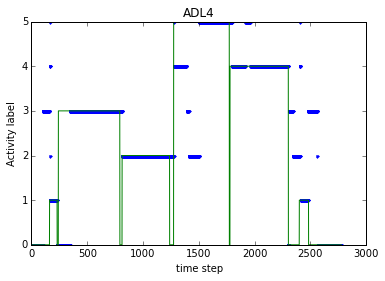

In [48]:
# Test with ADL4, ADL5
seq4, logP4 = hmm_gmm.viterbi(test_reduced[:test_len[0], :])
seq5, logP5 = hmm_gmm.viterbi(test_reduced[test_len[0]: test_len[0] + test_len[1], :])

plt.plot(seq4 - 1, '.', label="estimated label")
plt.plot(np.maximum(0, test_labels[: test_len[0]] - 100), '-', label="true label")
plt.xlabel('time step')
plt.ylabel('Activity label')
plt.title("ADL4")

predicted_4 = seq4 - 1
true_4 = np.maximum(0, test_labels[: test_len[0]] - 100)
print "accuracy: ", sum(predicted_4 == true_4) / float(test_len[0])

In [49]:
# Check if the results conforms with transition prob
# For label 5, collect trainsition i -> 5. 
# i should only be in {2, 5}
import collections
def count_state(label_seq, n_states):
   
    label_seq = (label_seq)
    counter_list = [collections.Counter() for i in range(0, n_states)]
    for t in range(1, len(label_seq)):
        counter_list[int(label_seq[t])][int(label_seq[t - 1])] += 1
    return counter_list

count4 = count_state(predicted_4, 6)

In [50]:
for state in range(0, n_states):
    print "state j = ", state, " state i: ", count4[state]

state j =  0  state i:  Counter({0: 437, 1: 1, 2: 1, 4: 1})
state j =  1  state i:  Counter({1: 125, 4: 2})
state j =  2  state i:  Counter({2: 617, 3: 5})
state j =  3  state i:  Counter({3: 661, 0: 3, 1: 1, 4: 1})
state j =  4  state i:  Counter({4: 576, 5: 5})
state j =  5  state i:  Counter({5: 336, 2: 4, 4: 1})


(1000, 2000)

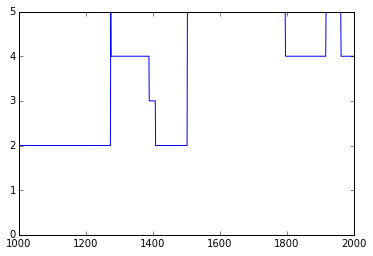

In [34]:
plt.plot(seq4 - 1, '-', label="estimated label")
plt.xlim((1000, 2000))

# why 4 -> 5 ?

In [35]:
# revisit gmm model, check logprob
i = 5
logp_x = outputdistr_gmm[i].logprob(train_reduced[train_label_transfer == i, :])
logp_x

array([[-255.81607308, -264.73729837, -260.99795925, ..., -270.23160204,
        -269.02055346, -258.87058194]])

In [36]:
# 1. in viterbi: want to preserve: if pij=0, pij * p(x | j) = 0, i.e., log(0) + any real number is -Inf.
# 2. check gmm logprob should in the range -0.01